In [28]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

In [20]:
# Load and shuffle data to prevent ordered outcomes
data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data_final.csv')
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify class distribution
print("Class distribution after shuffling:")
print(data['target'].value_counts(normalize=True))

# Split features and target
X = data.drop('target', axis=1)
y = data['target']

Class distribution after shuffling:
target
1    0.500061
0    0.499939
Name: proportion, dtype: float64


In [21]:
# First split: 80% train-val, 20% test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"\nTrain-val size: {len(X_trainval)}, Test size: {len(X_test)}")
print("Test set class distribution:", np.unique(y_test, return_counts=True))


Train-val size: 13105, Test size: 3277
Test set class distribution: (array([0, 1]), array([1638, 1639]))


In [22]:
# Scale only using train-val data
scaler = StandardScaler()
X_trainval_scaled = scaler.fit_transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_trainval = pd.DataFrame(X_trainval_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

# Calculate class weights based on TRAINING DATA ONLY
classes = np.unique(y_trainval)
weights = compute_class_weight('balanced', classes=classes, y=y_trainval)
class_weights = dict(zip(classes, weights))

In [23]:
# Revised parameter grid for LightGBM
param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [31, 50],
    'max_depth': [7, 15],
    'learning_rate': [0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0.1],
    'reg_lambda': [0.1],
    'min_child_samples': [20, 50],
    'scale_pos_weight': [1, len(y_trainval[y_trainval==0])/len(y_trainval[y_trainval==1])]
}

model = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    n_estimators=200,
    device='gpu',
    n_jobs=-1,
    verbose=-1,
    random_state=42
)

# Inner CV for grid search
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=inner_cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_trainval, y_trainval)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 128 candidates, totalling 384 fits



=== Final Test Set Performance ===
ROC AUC: 0.9980
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1638
           1       0.98      0.98      0.98      1639

    accuracy                           0.98      3277
   macro avg       0.98      0.98      0.98      3277
weighted avg       0.98      0.98      0.98      3277



<Figure size 800x600 with 0 Axes>

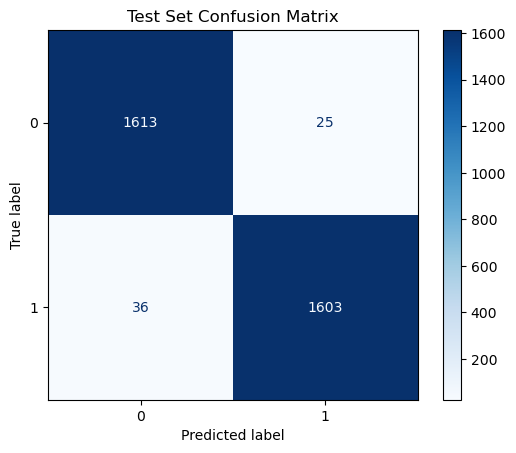

In [24]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("\n=== Final Test Set Performance ===")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title('Test Set Confusion Matrix')
    plt.show()
    
    return y_proba

y_proba = evaluate_model(best_model, X_test, y_test)

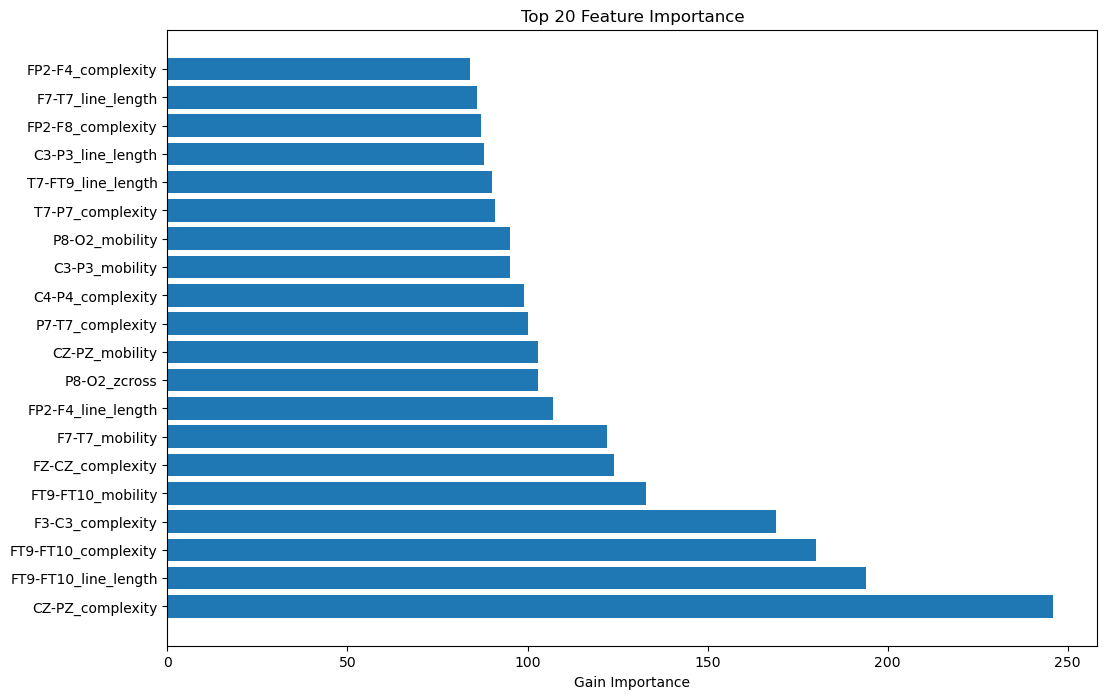

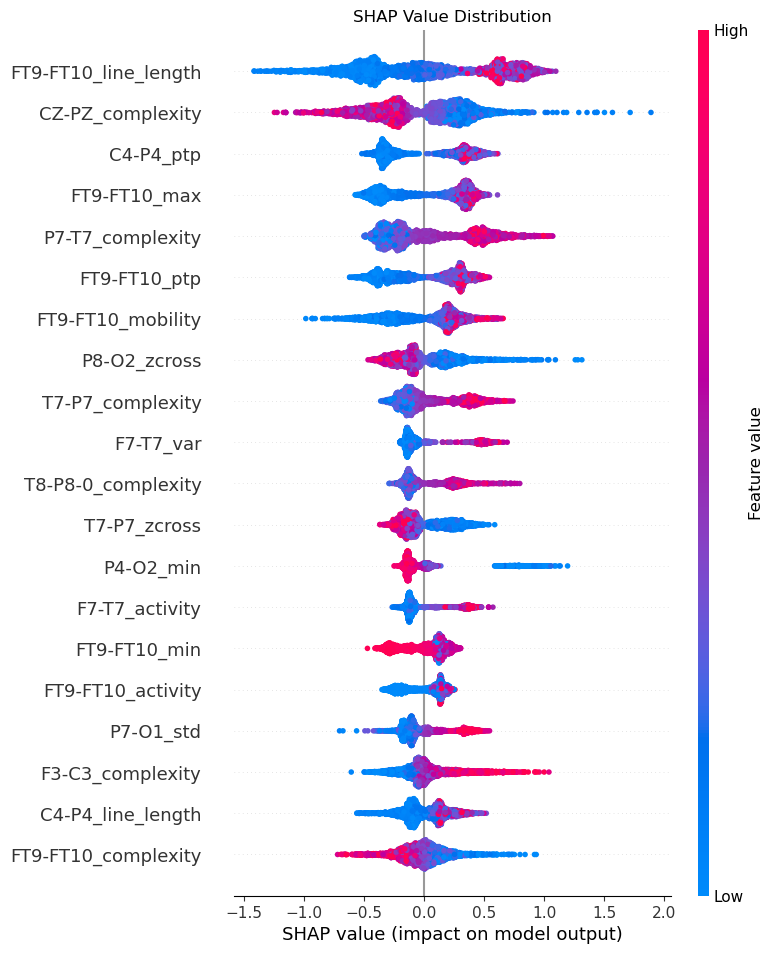

In [30]:
import warnings

warnings.filterwarnings("ignore")

def plot_feature_importance(model, features):
    importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.barh(importance['Feature'][:20], importance['Importance'][:20])
    plt.title('Top 20 Feature Importance')
    plt.xlabel('Gain Importance')
    plt.show()

def shap_analysis(model, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, show=False)
    plt.title('SHAP Value Distribution')
    plt.show()

plot_feature_importance(best_model, X.columns)
shap_analysis(best_model, X_test)

In [29]:
print("\n=== Nested Cross-Validation ===")
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use only train-val data for CV
cv_scores = cross_validate(
    grid_search.best_estimator_,
    X_trainval,
    y_trainval,
    cv=outer_cv,
    scoring=['roc_auc', 'accuracy', 'f1'],
    return_train_score=True,
    n_jobs=-1
)

print(f"Validation ROC AUC: {np.mean(cv_scores['test_roc_auc']):.4f} (±{np.std(cv_scores['test_roc_auc']):.4f})")
print(f"Validation F1: {np.mean(cv_scores['test_f1']):.4f}")


=== Nested Cross-Validation ===
Validation ROC AUC: 0.9969 (±0.0009)
Validation F1: 0.9759


In [31]:
print("\n=== Optimal Parameters ===")
print(grid_search.best_params_)

# Retrain on combined train-val data
final_model = grid_search.best_estimator_.fit(X_trainval, y_trainval)


=== Optimal Parameters ===
{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 15, 'min_child_samples': 50, 'num_leaves': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'scale_pos_weight': 0.9998473981382573, 'subsample': 0.8}
